# Chapter 11 - Forecasting Multiple Outputs

In many
circumstances observations are take simultaneously on two or
more time series.

For example, in hydrology we might observe
precipitation, discharge, soil humidity and water temperature
at the same site for the same sequence of time points. In financial
economics, we may be interested in modelling the opening
and closing price of IBM, Microsoft and Apple over a several
weeks or months. Multivariate data such as this can be easily
handled in a neural network.

In this chapter, we build a RNN to predict the historical
volatility of the FTSE100 stock market index and the Dow
Jones Industrial index. The FTSE is an index of the 100 companies
listed on the London Stock Exchange with the highest
market capitalization. The Dow Jones Industrial Average is the
average value of 30 large, industrial stocks traded on the New
York Stock Exchange and the NASDAQ.

In [1]:
import numpy as np
import pandas as pd
import zipfile

In [2]:
loc = 'stockindexes.zip'
dest_location = '..\\TimeSeriesDeepLearning\\Data'
unzip = zipfile.ZipFile(loc, 'r')
unzip.extractall(dest_location)
unzip.close()

## Extraction of Spreadsheet Data
We have seen this code before, but now we have quite a few sheets in the Excel file.

In [4]:

Excel_file = pd.ExcelFile(dest_location + '\\' + loc[:-3] + 'xls')
print(Excel_file.sheet_names)

for name in Excel_file.sheet_names:
    print(name)

['Description', 'Dow Jones Industrial', 'S&P500', 'NIKKEI 300', 'Dax30', 'CAC40', 'Swiss Market-Price Index', 'Mib30', 'IBEX 35I', 'Bel20', 'FTSE100']
Description
Dow Jones Industrial
S&P500
NIKKEI 300
Dax30
CAC40
Swiss Market-Price Index
Mib30
IBEX 35I
Bel20
FTSE100


We only want to work with the data for the FTSE 100 and Dow Jones indexes.

In [5]:
ftse_data = Excel_file.parse("FTSE100")
dj_data = Excel_file.parse("Dow Jones Industrial")

In [6]:
ftse_data.head(10)

,Start,1995-11-30 00:00:00
0,End,2000-02-18 00:00:00
1,Frequency,D
2,Name,FTSE 100 - PRICE INDEX
3,Code,FTSE100
4,1995-11-30 00:00:00,3664.3
5,1995-12-01 00:00:00,3680.4
6,1995-12-04 00:00:00,3669.7
7,1995-12-05 00:00:00,3664.2
8,1995-12-06 00:00:00,3662.8
9,1995-12-07 00:00:00,3639.5


In [7]:
dj_data.head(10)

,Start,1995-11-30 00:00:00
0,End,2000-02-18 00:00:00
1,Frequency,D
2,Name,DOW JONES INDUSTRIALS - PRICE INDEX
3,Code,DJINDUS
4,1995-11-30 00:00:00,5074.49
5,1995-12-01 00:00:00,5087.13
6,1995-12-04 00:00:00,5139.52
7,1995-12-05 00:00:00,5177.45
8,1995-12-06 00:00:00,5199.13
9,1995-12-07 00:00:00,5159.39


In [8]:
ftse100 = ftse_data.iloc[4:1357, 1]
dj = dj_data.iloc[4:1357, 1]

Let's see what this looks like...

No handles with labels found to put in legend.


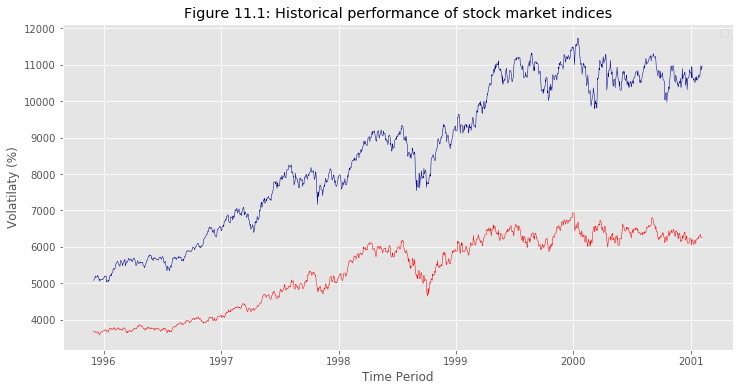

In [9]:
# FIGURE 11.1 (p.156)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

# FTSE 100 Data
xs = ftse_data.iloc[4:1375, 0]
ys = ftse_data.iloc[4:1375, 1]
plt.plot(xs, ys, '-', color="red", linewidth='0.5')

# Dow Jones Data
xs = dj_data.iloc[4:1375, 0]
ys = dj_data.iloc[4:1375, 1]
plt.plot(xs, ys, '-', color="darkblue", linewidth='0.5')

# Dax 30
# xs = dax_data.iloc[4:1375, 0]
# ys = dax_data.iloc[4:1375, 1]
# plt.plot(xs, ys, '-', color="darkgreen", linewidth='0.5')

plt.title("Figure 11.1: Historical performance of stock market indices")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Time Period")
plt.legend()
plt.show()

### QUESTIONS
Are there any trends in the time series data for these indicies?

## Check Data Values

In [11]:
ftse100.head()

4    3664.3
5    3680.4
6    3669.7
7    3664.2
8    3662.8
Name: 1995-11-30 00:00:00, dtype: object

In [12]:
ftse100.tail()

1352    6334.53
1353    6297.53
1354    6251.83
1355    6256.43
1356    6269.21
Name: 1995-11-30 00:00:00, dtype: object

In [13]:
dj.head()

4    5074.49
5    5087.13
6    5139.52
7    5177.45
8    5199.13
Name: 1995-11-30 00:00:00, dtype: object

In [14]:
dj.tail()

1352    10881.2
1353    10887.4
1354    10983.6
1355    10864.1
1356    10965.9
Name: 1995-11-30 00:00:00, dtype: object

## How to Work with Multiple Targets

The goal is to predict the 30 day historical volatility (standard
deviation) of the daily price change. Our first step is to create
the target variables. Let’s begin by concatenating the price
series into one Python object yt

In [15]:
yt = pd.concat([ftse100, dj], axis=1)
yt.head()

,1995-11-30,1995-11-30
4,3664.3,5074.49
5,3680.4,5087.13
6,3669.7,5139.52
7,3664.2,5177.45
8,3662.8,5199.13


In [16]:
yt = yt.reset_index(drop=True)
yt.columns = ['ftse100', 'dj']
yt.head()

,ftse100,dj
0,3664.3,5074.49
1,3680.4,5087.13
2,3669.7,5139.52
3,3664.2,5177.45
4,3662.8,5199.13


The next step is:
- to convert the price levels into daily price percent changes
- and calculate the 30 day rolling standard deviation.

**pct_change** : function calculates the percentage change between the current and a prior element. This function by default calculates the percentage change from the immediately previous row. The first row contains NaN values, as there is no previous row from which we can calculate the change.

**dataframe.rolling:** In a very simple words we take a window size of k at a time and perform some desired mathematical operation on it. A window of size k means k consecutive values at a time. In a very simple case all the ‘k’ values are equally weighted.

In [17]:
yt = yt.pct_change()
yt.head()
win = 30  # Remember this choice!
vol_t = yt.rolling(window=win, center=True).std()
vol_t.head(20)

,ftse100,dj
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [21]:
vol_t

,ftse100,dj
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1348,NaN,NaN
1349,NaN,NaN
1350,NaN,NaN
1351,NaN,NaN


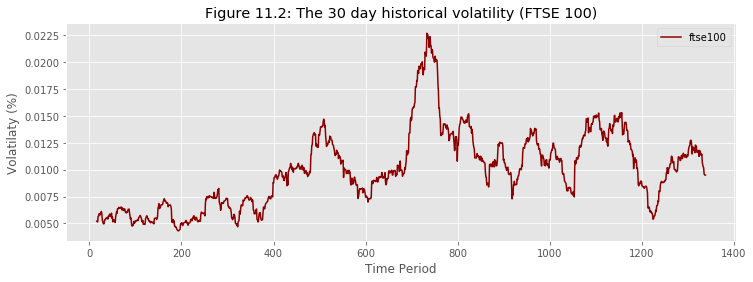

In [22]:
# FIGURE 11.2 (p.160)
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,4)

# FTSE 100 Data
ftse_xs = np.arange(vol_t.shape[0])
ftse_ys = vol_t["ftse100"]
plt.plot(ftse_xs, ftse_ys, '-', label="ftse100", color="darkred")

plt.title("Figure 11.2: The 30 day historical volatility (FTSE 100)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Time Period")
plt.legend()
plt.show()

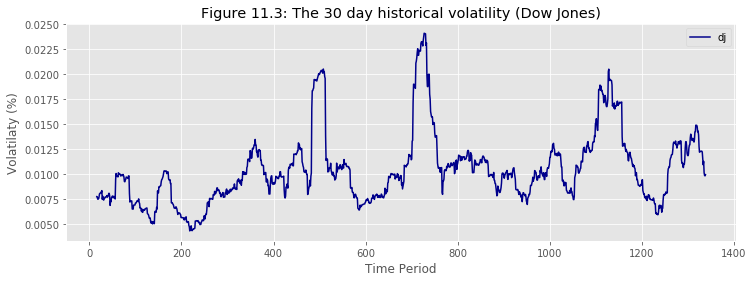

In [24]:
# FIGURE 11.2 (p.160)

# Dow Jones Data
dj_xs = np.arange(vol_t.shape[0])
dj_ys = vol_t["dj"]
plt.plot(dj_xs, dj_ys, '-', label="dj", color="darkblue")

plt.title("Figure 11.3: The 30 day historical volatility (Dow Jones)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Time Period")
plt.legend()
plt.show()

## Creation of Hand Crafted Features

Hand crafting features is both art and science. To spice
things up a little, we add five hand crafted features. Each
constructed along the following lines:

$$ \left [ \frac{volt_{t-1}}{volt_{t-k}}\right ] \times volt_{t-1}, k= 1,2,3,4,5 $$

In other words, at time t we use yesterday’s volatility adjusted
by the ratio of it to recent past values:

In [25]:
x1 = np.log((vol_t.shift(1) / vol_t.shift(2)) * vol_t.shift(1))
x2 = np.log((vol_t.shift(1) / vol_t.shift(3)) * vol_t.shift(1))
x3 = np.log((vol_t.shift(1) / vol_t.shift(4)) * vol_t.shift(1))
x4 = np.log((vol_t.shift(1) / vol_t.shift(5)) * vol_t.shift(1))
x5 = np.log((vol_t.shift(1) / vol_t.shift(6)) * vol_t.shift(1))

In [26]:
data = pd.concat([vol_t, x1, x2, x3, x4, x5], axis=1)
data.columns = ['ftse_t', 'dj_t',
                'ftse_t-1', 'dj_t-1',
                'ftse_t-2', 'dj_t-2',
                'ftse_t-3', 'dj_t-3',
                'ftse_t-4', 'dj_t-4',
                'ftse_t-5', 'dj_t-5',]
data = data.dropna()

## Target and Features in One Place

In [27]:
cols_y = ['ftse_t', 'dj_t']
y = data[cols_y]
cols = ['ftse_t-1', 'dj_t-1',
        'ftse_t-2', 'dj_t-2',
        'ftse_t-3', 'dj_t-3',
        'ftse_t-4', 'dj_t-4',
        'ftse_t-5', 'dj_t-5',]
x = data[cols]

## Scaling Data

In [28]:
from sklearn import preprocessing
num_attrib = 10
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1,1))
x = np.array(x).reshape((len(x), num_attrib))
x = scaler_x.fit_transform(x)

num_response = 2

scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1))
y = np.array(y).reshape((len(y), num_response))
y = scaler_y.fit_transform(y)

## Train and Test Sets

In [29]:
train_end = 1131
data_end = len(y)
x_train = x[0:train_end, ]
x_test = x[train_end + 1:data_end, ]
y_train = y[0:train_end]
y_test = y[train_end + 1:data_end]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [31]:
print("Shape of x_train is ", x_train.shape)

Shape of x_train is  (1131, 1, 10)


In [32]:
print( "Shape of x_test is ", x_test.shape)

Shape of x_test is  (185, 1, 10)


## Model Specification and Fit

In [33]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import SGD

Using TensorFlow backend.


In [34]:
seed = 2016
num_epochs=20
np.random.seed(seed)
fit1 = Sequential()
# UPDATED
# fit1.add(SimpleRNN(output_dim=10, activation='sigmoid', input_shape=(1, num_attrib)))
fit1.add(SimpleRNN(units=10, activation='sigmoid', input_shape=(1, num_attrib)))
# UPDATED
# fit1.add(Dense(output_dim=num_response, activation='linear'))
fit1.add(Dense(units=num_response, activation='linear'))
sgd = SGD(lr=0.01, momentum=0.90, nesterov=True)
fit1.compile(loss='mean_squared_error', optimizer=sgd)
fit1.fit(x_train, y_train, batch_size=1, epochs=num_epochs)

W0222 23:20:20.813991 63056 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0222 23:20:20.831977 63056 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0222 23:20:20.839965 63056 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0222 23:20:20.968989 63056 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\optimizers.py:79

Epoch 1/20
1131/1131 [==============================] - 2s 1ms/step - loss: 0.0089
Epoch 2/20
1131/1131 [==============================] - 1s 860us/step - loss: 0.0038
Epoch 3/20
1131/1131 [==============================] - 1s 878us/step - loss: 0.0034
Epoch 4/20
1131/1131 [==============================] - 1s 881us/step - loss: 0.0031
Epoch 5/20
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 6/20
1131/1131 [==============================] - 1s 1ms/step - loss: 0.0027
Epoch 7/20
1131/1131 [==============================] - 1s 856us/step - loss: 0.0026
Epoch 8/20
1131/1131 [==============================] - 1s 849us/step - loss: 0.0025
Epoch 9/20
1131/1131 [==============================] - 1s 849us/step - loss: 0.0023
Epoch 10/20
1131/1131 [==============================] - 1s 852us/step - loss: 0.0023
Epoch 11/20
1131/1131 [==============================] - 1s 886us/step - loss: 0.0022
Epoch 12/20
1131/1131 [==============================] - 1s 1ms/step 

In [36]:
score_train = fit1.evaluate(x_train, y_train, batch_size=1)
score_test = fit1.evaluate(x_test, y_test, batch_size=1)
print 
print( "in train  MSE = ", round(score_train, 5))
print( "in test   MSE = ", round(score_test, 5))

185/185 [==============================] - 0s 584us/step
in train  MSE =  0.00171
in test   MSE =  0.00127


In [37]:
pred1 = fit1.predict(x_test)
pred1 = scaler_y.inverse_transform(np.array(pred1).reshape((len(pred1), 2)))

## Visualizing the Results

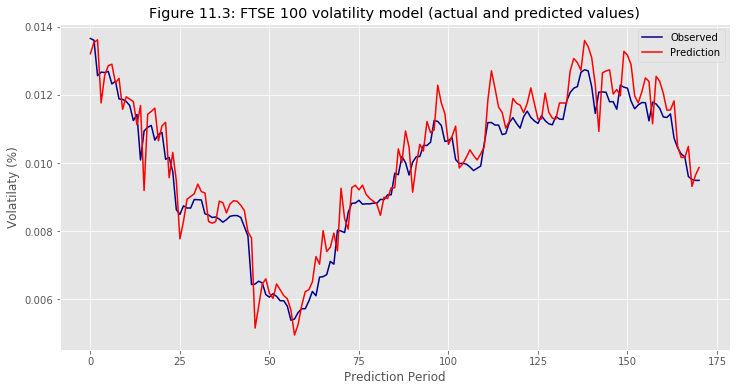

In [38]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

# FIGURE 11.3 (p. 165)
# FTSE 100 Data
ftse_pred = pred1[:, 0]

plt.plot(range(185), ftse_ys[-(185):], '-', label="Observed", color="darkblue")
plt.plot(range(185-14), ftse_pred.tolist()[-(185-14):], "-", label="Prediction", color="red")

plt.title("Figure 11.3: FTSE 100 volatility model (actual and predicted values)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Prediction Period")
plt.legend()
plt.show()

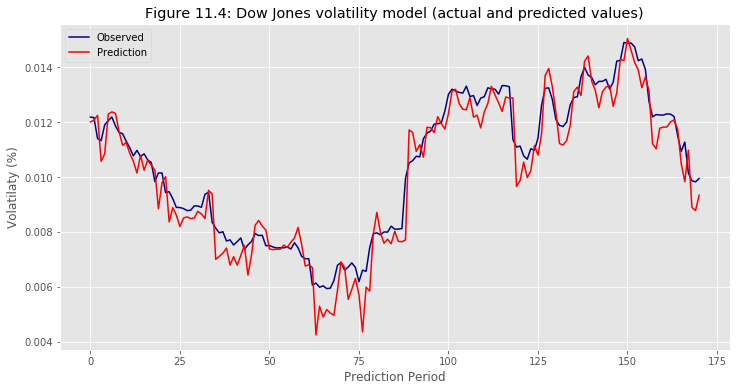

In [39]:
# FIGURE 11.4 (p. 166)
# Dow Jones Data
dj_pred = pred1[:, 1]

plt.plot(range(185), dj_ys[-(185):], '-', label="Observed", color="darkblue")
plt.plot(range(185-14), dj_pred.tolist()[-(185-14):], "-", label="Prediction", color="red")

plt.title("Figure 11.4: Dow Jones volatility model (actual and predicted values)")
plt.ylabel("Volatilaty (%)")
plt.xlabel("Prediction Period")
plt.legend()
plt.show()